In [78]:
import pandas as pd
import numpy as np
import pickle
import csv
import datetime as dt

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder

from xgboost import XGBRFRegressor

import matplotlib.pyplot as plt
import seaborn as sns

import os
import copy
import math

import warnings
warnings.filterwarnings('ignore')

In [79]:
#pip install scikit-learn==1.2.2

In [80]:
#pip install xgboost --upgrade

In [81]:
df = pd.read_csv('/kaggle/input/dataset/train.csv')
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [82]:
df.sample(5)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
8204,FDL33,7.235,Low Fat,0.167317,Snack Foods,197.5452,OUT010,1998,NaN,Tier 3,Grocery Store,195.7452
2668,FDV16,7.750,Regular,0.082915,Frozen Foods,34.9558,OUT035,2004,Small,Tier 2,Supermarket Type1,645.1602
4263,FDR15,NaN,Regular,0.058546,Meat,155.8314,OUT019,1985,Small,Tier 1,Grocery Store,310.2628
6334,FDF41,NaN,Low Fat,0.130545,Frozen Foods,248.0460,OUT027,1985,Medium,Tier 3,Supermarket Type3,7883.0720
2256,FDY10,17.600,Low Fat,0.049144,Snack Foods,112.7176,OUT049,1999,Medium,Tier 1,Supermarket Type1,1717.7640


In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [84]:
df.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [85]:
df.isnull().sum() * 100 / len(df)

Item_Identifier               0.000000
Item_Weight                  17.165317
Item_Fat_Content              0.000000
Item_Visibility               0.000000
Item_Type                     0.000000
Item_MRP                      0.000000
Outlet_Identifier             0.000000
Outlet_Establishment_Year     0.000000
Outlet_Size                  28.276428
Outlet_Location_Type          0.000000
Outlet_Type                   0.000000
Item_Outlet_Sales             0.000000
dtype: float64

In [86]:
df.duplicated().any() #.any() returns true if atleast one duplicated value is present

False

In [87]:
df.shape

(8523, 12)

In [88]:
#two columns has missing values, so lets fix them
#Item_Weight and Outlet_Size
iw_mean = df.Item_Weight.mean()
iw_median = df.Item_Weight.median()
print(iw_mean, iw_median)

12.857645184135976 12.6


In [89]:
df_copy = df.copy()
df_copy['Item_Weight_mean']=df_copy['Item_Weight'].fillna(iw_mean)
df_copy['Item_Weight_median']=df_copy['Item_Weight'].fillna(iw_median)
df_copy.sample(10)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_Weight_mean,Item_Weight_median
7886,FDP57,17.50,low fat,0.052434,Snack Foods,103.9990,OUT035,2004,Small,Tier 2,Supermarket Type1,1857.5820,17.500000,17.50
6694,FDX50,20.10,Low Fat,0.075049,Dairy,110.4228,OUT017,2007,NaN,Tier 2,Supermarket Type1,1105.2280,20.100000,20.10
1733,FDJ27,17.70,Regular,0.122123,Meat,100.7674,OUT045,2002,NaN,Tier 2,Supermarket Type1,814.9392,17.700000,17.70
5193,FDE05,NaN,Regular,0.032297,Frozen Foods,144.0102,OUT027,1985,Medium,Tier 3,Supermarket Type3,5394.9774,12.857645,12.60
977,NCC43,7.39,Low Fat,0.093308,Household,250.9066,OUT017,2007,NaN,Tier 2,Supermarket Type1,1506.0396,7.390000,7.39
2817,DRF03,19.10,Low Fat,0.045379,Dairy,42.4138,OUT049,1999,Medium,Tier 1,Supermarket Type1,243.6828,19.100000,19.10
340,FDY49,NaN,Regular,0.011954,Canned,164.5184,OUT027,1985,Medium,Tier 3,Supermarket Type3,2807.0128,12.857645,12.60
1442,FDM57,11.65,Regular,0.075849,Snack Foods,85.1908,OUT046,1997,Small,Tier 1,Supermarket Type1,2181.1608,11.650000,11.65
4603,FDQ15,20.35,Regular,0.000000,Meat,81.6276,OUT046,1997,Small,Tier 1,Supermarket Type1,1787.0072,20.350000,20.35
682,FDT01,13.65,Regular,0.185209,Canned,212.9902,OUT017,2007,NaN,Tier 2,Supermarket Type1,3185.8530,13.650000,13.65


In [90]:
print("Original Weight variable variance",df_copy['Item_Weight'].var())
print("Item Weight variance after mean imputation",df_copy['Item_Weight_mean'].var())
print("Item Weight variance after median imputation",df_copy['Item_Weight_median'].var())   #variance decreases indicating the points coming closer to mean value

Original Weight variable variance 21.561688259836558
Item Weight variance after mean imputation 17.86012173506058
Item Weight variance after median imputation 17.869561454073647


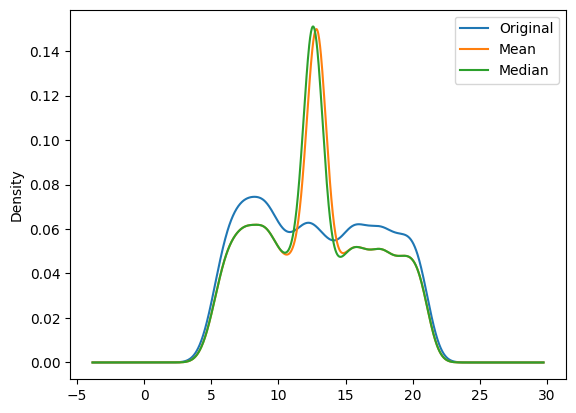

In [91]:
df_copy['Item_Weight'].plot(kind = "kde",label="Original")

df_copy['Item_Weight_mean'].plot(kind = "kde",label = "Mean")

df_copy['Item_Weight_median'].plot(kind = "kde",label = "Median")

plt.legend()
plt.show()

In [92]:
#now using interpolation method for predicting the values of nan
df_copy['Item_Weight_interploate']=df_copy['Item_Weight'].interpolate(method="linear")

df_copy['Item_Weight']: This selects the Item_Weight column of the df_copy DataFrame, which likely contains some missing values (NaN).

.interpolate(...): This is a Pandas function that fills in missing values using various interpolation methods.

method="linear": This specifies the type of interpolation to use. "Linear" interpolation estimates missing values by assuming a straight line between the known data points. In simpler terms, it connects the dots with straight lines to fill in the gaps.

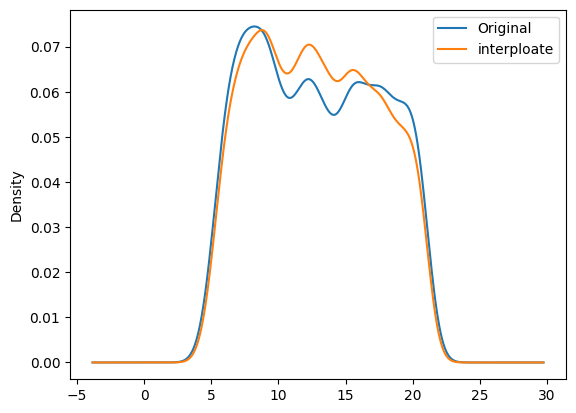

In [93]:
df_copy['Item_Weight'].plot(kind = "kde",label="Original")

df_copy['Item_Weight_interploate'].plot(kind = "kde",label = "interploate")

plt.legend()
plt.show() #better than mean median method because distributions are closer

In [94]:
#now using ML methods to predict nan values
knn = KNNImputer(n_neighbors = 10, weights = 'distance')
df_copy['Item_Weight_knn']=knn.fit_transform(df_copy[['Item_Weight']]).ravel()

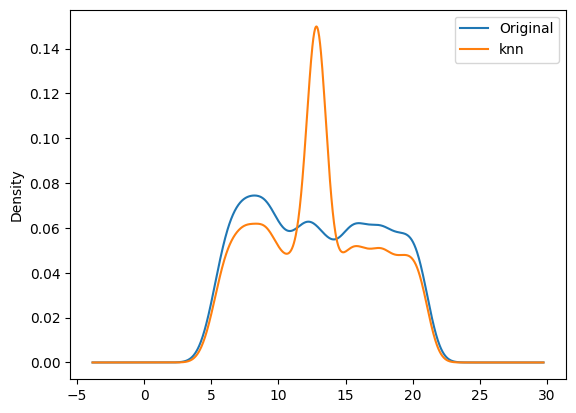

In [95]:
df_copy['Item_Weight'].plot(kind = "kde",label="Original")

df_copy['Item_Weight_knn'].plot(kind = "kde",label = "knn")

plt.legend()
plt.show()

In [96]:
df_copy.head(5)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_Weight_mean,Item_Weight_median,Item_Weight_interploate,Item_Weight_knn
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,9.30,9.30,9.30,9.30
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,5.92,5.92,5.92,5.92
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,17.50,17.50,17.50,17.50
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800,19.20,19.20,19.20,19.20
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,8.93,8.93,8.93,8.93


we can clearly see interpolation gives us the best result here



thus we are gonna use that only and drop the original column too.

In [97]:
df_copy = df_copy.drop(['Item_Weight', 'Item_Weight_knn', 'Item_Weight_median', 'Item_Weight_mean'],axis=1)
df_copy.head()

,Item_Identifier,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_Weight_interploate
0,FDA15,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,9.30
1,DRC01,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,5.92
2,FDN15,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,17.50
3,FDX07,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800,19.20
4,NCD19,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,8.93


In [98]:
df_copy.isnull().sum()

Item_Identifier                 0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
Item_Weight_interploate         0
dtype: int64

In [99]:
#now another nan value column
#Outlet_Size has text values so we cant use mean or median here, so we have to use mode here
df_copy['Outlet_Size'].value_counts()

Outlet_Size
Medium    2793
Small     2388
High       932
Name: count, dtype: int64

In [100]:
#but the outlet_size column is related to Outlet_Type column cuz the type of outlet helps us in determining the size of the outlet
df_copy['Outlet_Type'].value_counts()

Outlet_Type
Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     935
Supermarket Type2     928
Name: count, dtype: int64

In [101]:
mode_outlet = df_copy.pivot_table(values='Outlet_Size',
                                  columns='Outlet_Type',
                                  aggfunc=(lambda x:x.mode()[0]))
mode_outlet

Outlet_Type,Grocery Store,Supermarket Type1,Supermarket Type2,Supermarket Type3
Outlet_Size,Small,Small,Medium,Medium


In [102]:
missing_values = df_copy['Outlet_Size'].isnull()
missing_values

0       False
1       False
2       False
3        True
4       False
        ...  
8518    False
8519     True
8520    False
8521    False
8522    False
Name: Outlet_Size, Length: 8523, dtype: bool

In [103]:
df_copy.loc[missing_values,'Outlet_Size'] = df_copy.loc[missing_values,'Outlet_Type'].apply(lambda x :mode_outlet[x])
df_copy.sample(5)

,Item_Identifier,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_Weight_interploate
6980,FDO46,Regular,0.014144,Snack Foods,187.3872,OUT027,1985,Medium,Tier 3,Supermarket Type3,2836.3080,13.233333
3808,FDT52,Regular,0.047503,Frozen Foods,244.6144,OUT049,1999,Medium,Tier 1,Supermarket Type1,3185.1872,9.695000
8093,FDP26,Low Fat,0.140121,Dairy,102.5306,OUT018,2009,Medium,Tier 3,Supermarket Type2,1358.8978,7.785000
6037,FDE59,LF,0.104257,Starchy Foods,34.0532,OUT010,1998,Small,Tier 3,Grocery Store,179.7660,12.150000
7056,FDP08,Regular,0.112638,Fruits and Vegetables,195.5478,OUT045,2002,Small,Tier 2,Supermarket Type1,3874.9560,20.500000


In [104]:
df_copy.isnull().sum()

Item_Identifier              0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
Item_Weight_interploate      0
dtype: int64

In [105]:
df_copy.Item_Fat_Content.value_counts()

Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: count, dtype: int64

In [106]:
#low fat has 3 columns and reg or regular has 2, so lets merge them
df_copy['Item_Fat_Content'] = df_copy['Item_Fat_Content'].replace({'LF':'Low Fat',
                                                             'reg':'Regular',
                                                             'low fat':'Low Fat'})
df_copy.Item_Fat_Content.value_counts()

Item_Fat_Content
Low Fat    5517
Regular    3006
Name: count, dtype: int64

In [107]:
#similarly for Item_Visibility
df_copy.Item_Visibility.value_counts()

Item_Visibility
0.000000    526
0.076975      3
0.162462      2
0.076841      2
0.073562      2
           ... 
0.013957      1
0.110460      1
0.124646      1
0.054142      1
0.044878      1
Name: count, Length: 7880, dtype: int64

In [108]:
#we are gonna replace the zeros with nan and use interpolate to fill those, cuz we treat zeros as missing values
df_copy['Item_Visibility_interpolate']=df_copy['Item_Visibility'].replace(0,np.nan).interpolate(method='linear')
df_copy = df_copy.drop(['Item_Visibility'],axis=1)
df_copy.Item_Visibility_interpolate.value_counts()

Item_Visibility_interpolate
0.076975    3
0.044024    2
0.040912    2
0.076856    2
0.078759    2
           ..
0.021011    1
0.099189    1
0.076866    1
0.014116    1
0.044878    1
Name: count, Length: 8405, dtype: int64

In [109]:
#before dropping we can also compare by plotting graphs of those two, just like the above one

In [110]:
df_copy.head()

,Item_Identifier,Item_Fat_Content,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_Weight_interploate,Item_Visibility_interpolate
0,FDA15,Low Fat,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,9.30,0.016047
1,DRC01,Regular,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,5.92,0.019278
2,FDN15,Low Fat,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,17.50,0.016760
3,FDX07,Regular,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800,19.20,0.015755
4,NCD19,Low Fat,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,8.93,0.014751


In [111]:
df_copy.Item_Identifier.value_counts()

Item_Identifier
FDW13    10
FDG33    10
NCY18     9
FDD38     9
DRE49     9
         ..
FDY43     1
FDQ60     1
FDO33     1
DRF48     1
FDC23     1
Name: count, Length: 1559, dtype: int64

In [112]:
df_copy.Item_Identifier.sample(10)

4520    FDQ44
1564    FDE34
996     NCL30
7900    FDD17
4117    FDZ44
455     NCE43
4586    FDC45
1702    FDZ59
819     FDV45
275     FDH19
Name: Item_Identifier, dtype: object

In [113]:
#we can see each Item_Identifier starts with either fd, nc or dr, indicating it might be fd: food, dr: drinks, nc: non consumables
df_copy['Item_Type_Combined'] = df_copy['Item_Identifier'].apply(lambda x : x[:2])
df_copy.Item_Type_Combined.value_counts()

Item_Type_Combined
FD    6125
NC    1599
DR     799
Name: count, dtype: int64

lambda x : x[:2] is an anonymous function (using a lambda keyword) that takes a value x (representing an Item_Identifier) and returns the first two characters of that value (x[:2]).

In [114]:
df_copy.head()

,Item_Identifier,Item_Fat_Content,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_Weight_interploate,Item_Visibility_interpolate,Item_Type_Combined
0,FDA15,Low Fat,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,9.30,0.016047,FD
1,DRC01,Regular,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,5.92,0.019278,DR
2,FDN15,Low Fat,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,17.50,0.016760,FD
3,FDX07,Regular,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800,19.20,0.015755,FD
4,NCD19,Low Fat,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,8.93,0.014751,NC


In [115]:
df_copy.columns

Index(['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Item_MRP',
       'Outlet_Identifier', 'Outlet_Establishment_Year', 'Outlet_Size',
       'Outlet_Location_Type', 'Outlet_Type', 'Item_Outlet_Sales',
       'Item_Weight_interploate', 'Item_Visibility_interpolate',
       'Item_Type_Combined'],
      dtype='object')

In [116]:
#now lets make the establishment year into age of each store
current_year = dt.datetime.today().year
current_year

2025

In [117]:
df_copy['outlet_age'] = current_year - df_copy['Outlet_Establishment_Year']
df_copy.head()

,Item_Identifier,Item_Fat_Content,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_Weight_interploate,Item_Visibility_interpolate,Item_Type_Combined,outlet_age
0,FDA15,Low Fat,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,9.30,0.016047,FD,26
1,DRC01,Regular,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,5.92,0.019278,DR,16
2,FDN15,Low Fat,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,17.50,0.016760,FD,26
3,FDX07,Regular,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800,19.20,0.015755,FD,27
4,NCD19,Low Fat,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,8.93,0.014751,NC,38


In [118]:
#now lets drop the columns we wont use
df_copy = df_copy.drop(['Item_Identifier','Outlet_Establishment_Year'],axis=1)
df_copy.head()

,Item_Fat_Content,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_Weight_interploate,Item_Visibility_interpolate,Item_Type_Combined,outlet_age
0,Low Fat,Dairy,249.8092,OUT049,Medium,Tier 1,Supermarket Type1,3735.1380,9.30,0.016047,FD,26
1,Regular,Soft Drinks,48.2692,OUT018,Medium,Tier 3,Supermarket Type2,443.4228,5.92,0.019278,DR,16
2,Low Fat,Meat,141.6180,OUT049,Medium,Tier 1,Supermarket Type1,2097.2700,17.50,0.016760,FD,26
3,Regular,Fruits and Vegetables,182.0950,OUT010,Small,Tier 3,Grocery Store,732.3800,19.20,0.015755,FD,27
4,Low Fat,Household,53.8614,OUT013,High,Tier 3,Supermarket Type1,994.7052,8.93,0.014751,NC,38


now we need to convert the text values to numerical values because machines can only understand that.

but we cant use LabelEncoder as it works on output or target values 'y', not on input values 'x'

so we are going to use OrdinalEncoder


In [119]:
data_encoded = df_copy.copy()

cat_cols = df_copy.select_dtypes(include=['object']).columns

for col in cat_cols:
    oe = OrdinalEncoder()
    data_encoded[col]=oe.fit_transform(data_encoded[[col]])
    print(oe.categories_)

[array(['Low Fat', 'Regular'], dtype=object)]
[array(['Baking Goods', 'Breads', 'Breakfast', 'Canned', 'Dairy',
       'Frozen Foods', 'Fruits and Vegetables', 'Hard Drinks',
       'Health and Hygiene', 'Household', 'Meat', 'Others', 'Seafood',
       'Snack Foods', 'Soft Drinks', 'Starchy Foods'], dtype=object)]
[array(['OUT010', 'OUT013', 'OUT017', 'OUT018', 'OUT019', 'OUT027',
       'OUT035', 'OUT045', 'OUT046', 'OUT049'], dtype=object)]
[array(['High', 'Medium', 'Small'], dtype=object)]
[array(['Tier 1', 'Tier 2', 'Tier 3'], dtype=object)]
[array(['Grocery Store', 'Supermarket Type1', 'Supermarket Type2',
       'Supermarket Type3'], dtype=object)]
[array(['DR', 'FD', 'NC'], dtype=object)]


Let me explain this code which is performing ordinal encoding on categorical columns in a dataset.

Let's break it down line by line:

```python
data_encoded = df_copy.copy()
```
First, we create a copy of the original dataframe `df_copy`. This is good practice as it prevents modifying the original data.

```python
cat_cols = df_copy.select_dtypes(include=['object']).columns
```
This line finds all columns in the dataframe that have the data type 'object' (which typically means text/string columns in pandas) and gets their names. For example, if your dataframe had columns like 'name', 'color', 'category', these would be selected.

```python
for col in cat_cols:
    oe = OrdinalEncoder()
    data_encoded[col]=oe.fit_transform(data_encoded[[col]])
    print(oe.categories_)
```
This loop does the main encoding work:
1. For each categorical column, it creates a new OrdinalEncoder object
2. The encoder transforms the text values into numbers using `fit_transform()`
3. The encoded values are stored back in the same column in `data_encoded`
4. It prints the categories and their corresponding order

For example, if you had a 'color' column with values ['red', 'blue', 'green'], the encoder might transform them to [0, 1, 2], and `print(oe.categories_)` would show you this mapping.

One important note: Ordinal encoding assumes there's a meaningful order to the categories. If your categorical variables don't have a natural order (like colors or names), you might want to consider using OneHotEncoder instead, as ordinal encoding could introduce unwanted ordinal relationships in your data.

Would you like me to explain more about how ordinal encoding works or why we might choose it over other encoding methods?

In [120]:
data_encoded.head()

,Item_Fat_Content,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_Weight_interploate,Item_Visibility_interpolate,Item_Type_Combined,outlet_age
0,0.0,4.0,249.8092,9.0,1.0,0.0,1.0,3735.1380,9.30,0.016047,1.0,26
1,1.0,14.0,48.2692,3.0,1.0,2.0,2.0,443.4228,5.92,0.019278,0.0,16
2,0.0,10.0,141.6180,9.0,1.0,0.0,1.0,2097.2700,17.50,0.016760,1.0,26
3,1.0,6.0,182.0950,0.0,2.0,2.0,0.0,732.3800,19.20,0.015755,1.0,27
4,0.0,9.0,53.8614,1.0,0.0,2.0,1.0,994.7052,8.93,0.014751,2.0,38


In [121]:
#we are going to predict the Item_Outlet_Sales, so we shall drop it from data_encoded df in X and store it in y
X = data_encoded.drop(['Item_Outlet_Sales'],axis=1)
y = data_encoded['Item_Outlet_Sales']

In [122]:
X

,Item_Fat_Content,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Weight_interploate,Item_Visibility_interpolate,Item_Type_Combined,outlet_age
0,0.0,4.0,249.8092,9.0,1.0,0.0,1.0,9.300,0.016047,1.0,26
1,1.0,14.0,48.2692,3.0,1.0,2.0,2.0,5.920,0.019278,0.0,16
2,0.0,10.0,141.6180,9.0,1.0,0.0,1.0,17.500,0.016760,1.0,26
3,1.0,6.0,182.0950,0.0,2.0,2.0,0.0,19.200,0.015755,1.0,27
4,0.0,9.0,53.8614,1.0,0.0,2.0,1.0,8.930,0.014751,2.0,38
...,...,...,...,...,...,...,...,...,...,...,...
8518,0.0,13.0,214.5218,1.0,0.0,2.0,1.0,6.865,0.056783,1.0,38
8519,1.0,0.0,108.1570,7.0,2.0,1.0,1.0,8.380,0.046982,1.0,23
8520,0.0,8.0,85.1224,6.0,2.0,1.0,1.0,10.600,0.035186,2.0,21
8521,1.0,13.0,103.1332,3.0,1.0,2.0,2.0,7.210,0.145221,1.0,16


In [123]:
y

0       3735.1380
1        443.4228
2       2097.2700
3        732.3800
4        994.7052
          ...    
8518    2778.3834
8519     549.2850
8520    1193.1136
8521    1845.5976
8522     765.6700
Name: Item_Outlet_Sales, Length: 8523, dtype: float64

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### **When to Use Random Forest vs. Regression Methods**

#### **1. Random Forest**
- **Best Suited For:**
  - **Complex and Non-Linear Relationships:** Random Forest is a powerful ensemble method that can capture non-linear relationships between features and target variables.
  - **Classification or Regression Tasks:** Random Forest can handle both classification (categorical target) and regression (continuous target) problems.
  - **High-Dimensional Data:** Effective with many features, even if some are irrelevant.
  - **Robust to Outliers and Noise:** Individual decision trees in the forest can mitigate the effects of outliers and noise.

- **Examples:**
  - Predicting the probability of disease based on patient data (classification).
  - Estimating house prices based on features like location, size, and number of rooms (regression).
  - Image classification, feature ranking, and imputing missing data.

- **Advantages:**
  - Handles both categorical and continuous data.
  - Reduces overfitting through bagging (bootstrapping and aggregation).
  - Provides feature importance metrics.

- **Disadvantages:**
  - Computationally intensive for large datasets.
  - Can be harder to interpret compared to simpler regression models.

---

#### **2. Regression Methods**
- **Best Suited For:**
  - **Linear or Simple Relationships:** Used when there is a linear or straightforward relationship between features and the target.
  - **Continuous Target Variables:** Primarily designed for regression problems.
  - **Explainability:** Easier to interpret and explain compared to Random Forest.

- **Types of Regression:**
  - **Linear Regression:** For linear relationships between independent variables and the target.
  - **Logistic Regression:** For binary classification problems (though it outputs probabilities).
  - **Polynomial Regression:** For non-linear relationships that can be approximated by polynomials.

- **Examples:**
  - Predicting monthly sales revenue based on advertising spend.
  - Estimating temperature changes based on climate variables.
  - Understanding the effect of individual features on the target variable.

- **Advantages:**
  - Simple, fast, and interpretable.
  - Requires less computational power.
  - Works well with small datasets and fewer features.

- **Disadvantages:**
  - Assumes linearity (for linear regression).
  - Sensitive to outliers (unless robust regression methods are used).
  - May underperform if the relationship is highly non-linear or complex.

---

### **What Is a Continuous Target Variable?**
A **continuous target variable** is the dependent variable (or output) in a regression problem that can take on an infinite range of numeric values within a given range.

- **Examples of Continuous Target Variables:**
  - House prices (e.g., $100,000, $150,500, $200,000).
  - Temperature (e.g., 22.5°C, 35.8°C).
  - Stock prices (e.g., $50.25, $51.30, $52.10).
  - Blood pressure readings (e.g., 120.5 mmHg, 115.2 mmHg).

- **Contrast with Categorical Target Variables:**
  - Categorical targets are discrete and limited to specific groups or classes (e.g., "Yes" or "No", "Dog" or "Cat").

---

### **Choosing Between Random Forest and Regression**

#### **1. Use Random Forest If:**
- The data has complex, non-linear relationships.
- The dataset contains many features or irrelevant variables.
- Interpretability is less critical, and performance is the primary goal.
- You want robust predictions that aren't overly sensitive to outliers.

#### **2. Use Regression If:**
- The relationship between features and the target is linear or straightforward.
- Interpretability of the model coefficients is important.
- You need a simple, fast, and computationally inexpensive solution.
- The dataset is small or has fewer features.

---

Would you like further clarification or help with an example problem?

Using **Random Forest** and **XGBRFRegressor** together can be a powerful approach to improve model performance, especially when their strengths complement each other. Here’s when and how you might use both:

---

### **When to Use Random Forest and XGBRFRegressor Together**

#### **1. Stacking or Ensemble Learning**
- **Why?**
  - Random Forest and XGBRFRegressor have different ways of handling data. Combining their predictions can help capture diverse patterns and improve the overall performance.
  - Random Forest uses bagging, while XGBRFRegressor incorporates gradient boosting with random forest principles.
- **How?**
  - Use a meta-model (e.g., Linear Regression or another machine learning model) to combine predictions from Random Forest and XGBRFRegressor.
  - This technique works well for complex datasets with both linear and non-linear relationships.


#### **2. Complementary Strengths in Different Data Patterns**
- **Why?**
  - Random Forest may perform better when the dataset has many irrelevant features and noise due to its robust feature selection through random splits.
  - XGBRFRegressor might excel when the dataset has complex patterns and feature interactions due to gradient-boosting optimization.
- **How?**
  - Train both models separately and average or blend their predictions. This approach ensures the strengths of both models are utilized.



#### **3. Feature Importance Analysis**
- **Why?**
  - Random Forest provides a robust feature importance metric that can help identify key predictors.
  - Use Random Forest for feature selection and then train XGBRFRegressor on the reduced feature set for better performance.
- **How?**
  - Train Random Forest, extract important features, and use those features to train XGBRFRegressor.

---

#### **4. Dataset Exploration and Testing**
- **Why?**
  - If you're unsure which model performs better on your data, train both Random Forest and XGBRFRegressor and compare their results.
  - Use cross-validation to assess their performance individually or in combination.
- **How?**
  - Perform k-fold cross-validation on both models and compare metrics like mean squared error (MSE) or R².

---

### **When Not to Use Both Together**
1. **Small Datasets:**
   - Training multiple models might lead to overfitting or insignificant performance gains.
2. **Simple Problems:**
   - If the problem has a straightforward linear relationship, simpler models like Linear Regression or Ridge Regression might suffice.
3. **High Computational Cost:**
   - Both Random Forest and XGBRFRegressor can be computationally expensive, especially with large datasets.

---

### **Key Differences Between Random Forest and XGBRFRegressor**
| Feature                         | Random Forest                 | XGBRFRegressor                 |
|---------------------------------|--------------------------------|--------------------------------|
| Boosting Type                   | Bagging                       | Boosting with bagging elements |
| Overfitting Risk                | Lower                         | Lower with tuning              |
| Feature Interaction Handling    | Weaker                        | Strong                        |
| Training Speed                  | Faster                        | Slower (but optimized)         |

---

Would you like to try implementing one of these strategies?

In [124]:
#now making the regression model
rfr = RandomForestRegressor(n_estimators = 100, random_state = 42)
scores_rf = cross_val_score(rfr, X, y, cv=5, scoring='r2')
print(scores_rf.mean())

0.554934647787882


n_estimators=100 tells the model to create 100 different decision trees. Think of this like having 100 different experts making predictions, and then taking their average opinion. Having multiple trees helps reduce overfitting and makes predictions more robust. The number 100 is a common choice because it usually provides a good balance between model performance and computational efficiency.


random_state=42 is a seed value that ensures reproducibility. When a Random Forest creates its trees, it uses randomness in two ways: randomly selecting data points (bootstrap sampling) and randomly selecting features at each split. By setting a fixed random state, you ensure that you'll get the same results each time you run the model. The number 42 is arbitrary - any integer would work.

----------------------------------------------------------------------------------------------------------------------------------------------------------------

Let me give you a detailed explanation of this cross-validation code, which is a crucial technique for assessing how well your machine learning model will perform in real-world situations.

The line `scores = cross_val_score(rfr, X, y, cv=5, scoring='r2')` is implementing what we call k-fold cross-validation, where k=5. To understand this deeply, let's break down both the concept and how this specific implementation works.

Think of cross-validation like this: Imagine you're a teacher who wants to fairly assess how well students have learned the material. Instead of giving just one test (which might happen to be especially easy or hard), you give five different tests and average the scores. This gives you a much more reliable picture of student performance. Cross-validation does something very similar for machine learning models.

Here's what each parameter in the function does:
- `rfr`: Your Random Forest model that you want to evaluate
- `X`: Your feature data (the information you use to make predictions)
- `y`: Your target variable (what you're trying to predict)
- `cv=5`: This tells the function to do 5-fold cross-validation
- `scoring='r2'`: This specifies that you want to use the R² (R-squared) metric to evaluate performance

The process works like this:
1. First, the function divides your entire dataset into 5 equal-sized chunks
2. For each round (and there are 5 rounds):
   - It selects one chunk as the "test set"
   - It combines the other 4 chunks to form the "training set"
   - It trains the Random Forest model on the training set
   - It makes predictions on the test set and calculates the R² score
   - It stores this score and moves to the next round

Let's visualize one complete cycle:
```
Round 1: [Test][Train][Train][Train][Train]
Round 2: [Train][Test][Train][Train][Train]
Round 3: [Train][Train][Test][Train][Train]
Round 4: [Train][Train][Train][Test][Train]
Round 5: [Train][Train][Train][Train][Test]
```

The R² scores you get tell you how well your model explains the variance in your data. For instance, if you get scores like [0.82, 0.85, 0.83, 0.81, 0.84], this means:
- Your model explains between 81% and 85% of the variance in your target variable
- The variation in scores gives you an idea of how stable your model's performance is
- The mean of these scores (0.83) gives you a more reliable estimate of how your model will perform on new, unseen data

This approach has several advantages over simply splitting your data once into training and test sets:
1. Every data point gets to be in the test set exactly once
2. Every data point gets to be in the training set 4 times
3. You get a much more robust estimate of model performance
4. You can assess how consistent your model's performance is across different subsets of your data

Would you like me to explain more about how to interpret these R² scores, or shall we discuss strategies for improving model performance based on cross-validation results?

In [125]:
xg = XGBRFRegressor(n_estimators=100,random_state=42)
scores_xg = cross_val_score(xg,X,y,cv=5,scoring='r2')
print(scores_xg.mean())

0.595057121497181


In [126]:
#since xgbrf is better than normal random forest we are going to use that
#but theres no point in using these many features, so we are going to sort the features in terms of importance and
#use the top 5 imp features only

xgr = XGBRFRegressor(n_estimators=100,random_state=42)

xg_1 = xgr.fit(X,y)
pd.DataFrame({'feature':X.columns,'XGBRF_importance':xg_1.feature_importances_}).sort_values(by='XGBRF_importance',ascending=False)

,feature,XGBRF_importance
6,Outlet_Type,0.421423
10,outlet_age,0.171008
2,Item_MRP,0.150292
3,Outlet_Identifier,0.123782
4,Outlet_Size,0.116480
5,Outlet_Location_Type,0.008132
8,Item_Visibility_interpolate,0.002689
7,Item_Weight_interploate,0.002518
1,Item_Type,0.001595
9,Item_Type_Combined,0.001379


In [127]:
#lets drop the other columns
# ['Outlet_Location_Type', 'Item_Visibility_interpolate', 'Item_Weight_interploate', 'Item_Type', 'Item_Type_Combined', 'Item_Fat_Content']

xg = XGBRFRegressor(n_estimators=100,random_state=42)
scores_xg=cross_val_score(xg_1,X.drop(['Outlet_Location_Type', 'Item_Visibility_interpolate', 'Item_Weight_interploate', 'Item_Type', 'Item_Type_Combined', 'Item_Fat_Content'], axis=1), y,cv=5,scoring='r2')
print(scores_xg.mean())

0.5961723971108985


r2 score improved

In [128]:
final_df = X.drop(['Outlet_Location_Type', 'Item_Visibility_interpolate', 'Item_Weight_interploate', 'Item_Type', 'Item_Type_Combined', 'Item_Fat_Content'], axis=1)
final_df.head()

,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Type,outlet_age
0,249.8092,9.0,1.0,1.0,26
1,48.2692,3.0,1.0,2.0,16
2,141.6180,9.0,1.0,1.0,26
3,182.0950,0.0,2.0,0.0,27
4,53.8614,1.0,0.0,1.0,38


In [129]:
xgf = XGBRFRegressor()
xgf.fit(final_df, y)

XGBRFRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bytree=None, device=None,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, feature_types=None, gamma=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=None, n_jobs=None,
               num_parallel_tree=None, objective='reg:squarederror',
               random_state=None, reg_alpha=None, ...)

In [130]:
#lets check mean absolute error
train_test_split = train_test_split(final_df, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split

In [131]:
xgf.fit(X_train, y_train)
y_pred = xgf.predict(X_test)

In [132]:
mae = mean_absolute_error(y_test, y_pred)
print(mae)

714.5479888800818


In [133]:
#we can use p = xgf.predict (input) to predict the values

In [134]:
#using joblib to save it
import joblib
joblib.dump(xgf,'sales_model')

['sales_model']

In [135]:
model = joblib.load('sales_model')

In [136]:
#p = model.predict(np.array([[141.6180,9.0,1.0,1.0,24]]))[0]
#print(p)
#print(f"Sales Value is between {pred-714.55} and {pred+714.55}")

----------------------------------------------------------------------------------------------------------------------------------------------------------------
using test df

In [137]:
test_df = pd.read_csv('/kaggle/input/dataset/test.csv')
test_df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3


In [138]:
test_copy = test_df.copy()
test_copy['outlet_age'] = current_year - test_copy['Outlet_Establishment_Year']
test_copy['Item_Identifier'] = test_copy['Item_Identifier'].apply(lambda x : x[:2])
test_copy.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,outlet_age
0,FD,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1,26
1,FD,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1,18
2,NC,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store,27
3,FD,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1,18
4,FD,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3,40


In [139]:
test_copy.isnull().sum()

Item_Identifier                 0
Item_Weight                   976
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  1606
Outlet_Location_Type            0
Outlet_Type                     0
outlet_age                      0
dtype: int64

In [140]:
test_copy['Item_Weight_interploate']=test_copy['Item_Weight'].interpolate(method="linear")

In [141]:
test_copy.Outlet_Size.value_counts()

Outlet_Size
Medium    1862
Small     1592
High       621
Name: count, dtype: int64

In [142]:
test_copy.Outlet_Type.value_counts()

Outlet_Type
Supermarket Type1    3717
Grocery Store         722
Supermarket Type3     624
Supermarket Type2     618
Name: count, dtype: int64

In [143]:
mode_test = test_copy.pivot_table(values='Outlet_Size',
                                  columns='Outlet_Type',
                                  aggfunc=(lambda x:x.mode()[0]))
mode_test

Outlet_Type,Grocery Store,Supermarket Type1,Supermarket Type2,Supermarket Type3
Outlet_Size,Small,Small,Medium,Medium


In [144]:
missing_values = test_copy['Outlet_Size'].isnull()
missing_values

0       False
1        True
2        True
3        True
4       False
        ...  
5676    False
5677    False
5678     True
5679     True
5680     True
Name: Outlet_Size, Length: 5681, dtype: bool

In [145]:
test_copy.loc[missing_values,'Outlet_Size'] = test_copy.loc[missing_values,'Outlet_Type'].apply(lambda x :mode_outlet[x])
test_copy.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,outlet_age,Item_Weight_interploate
0,FD,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1,26,20.7500
1,FD,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,Small,Tier 2,Supermarket Type1,18,8.3000
2,NC,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,Small,Tier 3,Grocery Store,27,14.6000
3,FD,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,Small,Tier 2,Supermarket Type1,18,7.3150
4,FD,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3,40,8.5575


In [146]:
test_copy.drop(['Item_Weight', 'Outlet_Establishment_Year'], axis = 1)
test_copy.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,outlet_age,Item_Weight_interploate
0,FD,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1,26,20.7500
1,FD,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,Small,Tier 2,Supermarket Type1,18,8.3000
2,NC,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,Small,Tier 3,Grocery Store,27,14.6000
3,FD,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,Small,Tier 2,Supermarket Type1,18,7.3150
4,FD,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3,40,8.5575


In [147]:
test_copy['Item_Visibility'].value_counts()

Item_Visibility
0.000000    353
0.060879      2
0.097213      2
0.058461      2
0.058132      2
           ... 
0.082382      1
0.026175      1
0.155144      1
0.069557      1
0.104720      1
Name: count, Length: 5277, dtype: int64

In [148]:
test_copy['Item_Visibility_interpolate']=test_copy['Item_Visibility'].replace(0,np.nan).interpolate(method='linear')
test_copy = test_copy.drop(['Item_Visibility'],axis=1)
test_copy.Item_Visibility_interpolate.value_counts()

Item_Visibility_interpolate
0.093531    2
0.072816    2
0.202948    2
0.107493    2
0.112131    2
           ..
0.089452    1
0.133171    1
0.103428    1
0.073685    1
0.104720    1
Name: count, Length: 5629, dtype: int64

In [149]:
test_copy = test_copy.drop(['Item_Weight', 'Outlet_Establishment_Year'], axis = 1)

In [150]:
test_copy.head()

,Item_Identifier,Item_Fat_Content,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,outlet_age,Item_Weight_interploate,Item_Visibility_interpolate
0,FD,Low Fat,Snack Foods,107.8622,OUT049,Medium,Tier 1,Supermarket Type1,26,20.7500,0.007565
1,FD,reg,Dairy,87.3198,OUT017,Small,Tier 2,Supermarket Type1,18,8.3000,0.038428
2,NC,Low Fat,Others,241.7538,OUT010,Small,Tier 3,Grocery Store,27,14.6000,0.099575
3,FD,Low Fat,Snack Foods,155.0340,OUT017,Small,Tier 2,Supermarket Type1,18,7.3150,0.015388
4,FD,Regular,Dairy,234.2300,OUT027,Medium,Tier 3,Supermarket Type3,40,8.5575,0.118599


In [151]:
test_encoded = test_copy.copy()

test_cols = test_copy.select_dtypes(include=['object']).columns

for col in test_cols:
    oe = OrdinalEncoder()
    test_encoded[col]=oe.fit_transform(test_encoded[[col]])
    print(oe.categories_)

[array(['DR', 'FD', 'NC'], dtype=object)]
[array(['LF', 'Low Fat', 'Regular', 'low fat', 'reg'], dtype=object)]
[array(['Baking Goods', 'Breads', 'Breakfast', 'Canned', 'Dairy',
       'Frozen Foods', 'Fruits and Vegetables', 'Hard Drinks',
       'Health and Hygiene', 'Household', 'Meat', 'Others', 'Seafood',
       'Snack Foods', 'Soft Drinks', 'Starchy Foods'], dtype=object)]
[array(['OUT010', 'OUT013', 'OUT017', 'OUT018', 'OUT019', 'OUT027',
       'OUT035', 'OUT045', 'OUT046', 'OUT049'], dtype=object)]
[array(['High', 'Medium', 'Small'], dtype=object)]
[array(['Tier 1', 'Tier 2', 'Tier 3'], dtype=object)]
[array(['Grocery Store', 'Supermarket Type1', 'Supermarket Type2',
       'Supermarket Type3'], dtype=object)]


In [152]:
test_encoded.head()

,Item_Identifier,Item_Fat_Content,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,outlet_age,Item_Weight_interploate,Item_Visibility_interpolate
0,1.0,1.0,13.0,107.8622,9.0,1.0,0.0,1.0,26,20.7500,0.007565
1,1.0,4.0,4.0,87.3198,2.0,2.0,1.0,1.0,18,8.3000,0.038428
2,2.0,1.0,11.0,241.7538,0.0,2.0,2.0,0.0,27,14.6000,0.099575
3,1.0,1.0,13.0,155.0340,2.0,2.0,1.0,1.0,18,7.3150,0.015388
4,1.0,2.0,4.0,234.2300,5.0,1.0,2.0,3.0,40,8.5575,0.118599


In [153]:
final_test = test_encoded.drop(['Outlet_Location_Type', 'Item_Visibility_interpolate', 'Item_Weight_interploate', 'Item_Type', 'Item_Fat_Content', 'Item_Identifier'], axis=1)

In [154]:
final_test.head()

,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Type,outlet_age
0,107.8622,9.0,1.0,1.0,26
1,87.3198,2.0,2.0,1.0,18
2,241.7538,0.0,2.0,0.0,27
3,155.0340,2.0,2.0,1.0,18
4,234.2300,5.0,1.0,3.0,40


In [155]:
pred = model.predict(final_test)
print(pred)

[1630.4486  1446.1284   586.47144 ... 2028.3536  3647.536   1314.6456 ]


In [156]:
pred_series = pd.Series(pred)
pred_series.info()

<class 'pandas.core.series.Series'>
RangeIndex: 5681 entries, 0 to 5680
Series name: None
Non-Null Count  Dtype  
--------------  -----  
5681 non-null   float32
dtypes: float32(1)
memory usage: 22.3 KB


In [157]:
predictions_df = test_df[['Item_Identifier', 'Outlet_Identifier']]
predictions_df.head()

,Item_Identifier,Outlet_Identifier
0,FDW58,OUT049
1,FDW14,OUT017
2,NCN55,OUT010
3,FDQ58,OUT017
4,FDY38,OUT027


In [158]:
final_pred = pd.concat([predictions_df, pred_series], axis=1)
final_pred.head()

,Item_Identifier,Outlet_Identifier,0
0,FDW58,OUT049,1630.448608
1,FDW14,OUT017,1446.128418
2,NCN55,OUT010,586.471436
3,FDQ58,OUT017,2550.925537
4,FDY38,OUT027,6306.456055


In [159]:
final_pred = final_pred.rename(columns={0: 'Item_Outlet_Sales'})
final_pred.head()

,Item_Identifier,Outlet_Identifier,Item_Outlet_Sales
0,FDW58,OUT049,1630.448608
1,FDW14,OUT017,1446.128418
2,NCN55,OUT010,586.471436
3,FDQ58,OUT017,2550.925537
4,FDY38,OUT027,6306.456055


In [160]:
save = final_pred.to_csv('final_pred.csv', index=False)